In [1]:
import sys

sys.path.append('..')
from src.utils import evaluate

import torch
from PIL import Image
import imp
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

from PIL import Image
from pathlib import Path

from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor

print(torch.__version__)

C:\Users\denis\AppData\Local\Temp\ipykernel_20624\2460339843.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


1.12.0+cu116


In [2]:
from lavis.models import model_zoo

print(model_zoo)

Architectures                  Types
albef_classification           ve
albef_feature_extractor        base
albef_nlvr                     nlvr
albef_pretrain                 base
albef_retrieval                coco, flickr
albef_vqa                      vqav2
alpro_qa                       msrvtt, msvd
alpro_retrieval                msrvtt, didemo
blip_caption                   base_coco, large_coco
blip_classification            base
blip_feature_extractor         base
blip_image_text_matching       base, large
blip_nlvr                      nlvr
blip_pretrain                  base
blip_retrieval                 coco, flickr
blip_vqa                       vqav2, okvqa, aokvqa
pnp_vqa                        base, large, 3b
pnp_unifiedqav2_fid            
clip_feature_extractor         ViT-B-32, ViT-B-16, ViT-L-14, ViT-L-14-336, RN50
clip                           ViT-B-32, ViT-B-16, ViT-L-14, ViT-L-14-336, RN50
gpt_dialogue                   base


#### Load an example image and text

In [4]:
PART = 'test2'

PATH = Path('../data').resolve() / f"{PART}_v1"
PATH

WindowsPath('D:/ноука/semeval-2023-task-1-V-WSD-train-v1/repo/data/test2_v1')

In [5]:
data = pd.read_csv(PATH / f"{PART}.data.v1.txt", sep='\t', header=None)
data.columns = ['word', 'context'] + [f'image{i}' for i in range(10)]
data2 = pd.read_csv(PATH / f"{PART}.gold.v1.txt", sep='\t', header=None)
data['image_gold'] = data2

In [6]:
data

,word,context,image0,image1,image2,image3,image4,image5,image6,image7,image8,image9,image_gold
0,leucaena,leucaena genus,image.105.jpg,001546.jpg,000655.JPG,image.9520.jpg,image.15549.jpg,001206.JPG,001826.jpg,001597.jpg,002301.jpg,image.8849.jpg,image.105.jpg
1,mahonia,mahonia genus,001044.jpg,001674.jpg,000646.jpg,image.2680.jpg,001342.JPG,image.3494.jpg,000029.jpg,001720.jpg,image.120.jpg,image.2497.jpg,image.120.jpg
2,breakdown,breakdown failure,002145.jpg,image.7224.jpg,image.12060.jpg,image.8257.jpg,image.8257.jpg,image.239.jpg,image.9725.jpg,001788.jpg,image.5989.jpg,000801.jpg,image.239.jpg
3,boletellus,boletellus genus,image.6731.jpg,image.147.jpg,image.13701.jpg,image.13466.jpg,image.324.jpg,image.5049.jpg,000335.jpg,001961.JPG,001925.jpg,image.782.jpg,image.324.jpg
4,capparis,capparis genus,001593.jpg,001443.jpg,002213.jpg,image.359.jpg,image.6337.jpg,image.3602.jpg,000987.jpg,002117.JPG,image.5076.jpg,image.8718.jpg,image.359.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,aspergillus,aspergillus genus,image.593.jpg,000035.jpg,000389.jpg,image.5521.jpg,image.160.jpg,image.6272.jpg,image.8447.jpg,image.2497.jpg,image.10614.jpg,000567.jpg,image.10614.jpg
1555,mantophasmatodea,mantophasmatodea order,image.8286.jpg,image.5999.jpg,image.10599.jpg,image.3533.jpg,image.3355.jpg,002026.JPG,000778.jpg,001957.jpg,image.3467.jpg,002302.jpg,image.3355.jpg
1556,make,make persuade,image.10066.jpg,image.14200.jpg,image.8813.jpg,image.8879.jpg,002255.jpg,image.9126.jpg,image.14336.jpg,image.10167.jpg,001344.jpg,image.12437.jpg,image.9126.jpg
1557,lookout,lookout watcher,001229.jpg,001006.jpg,image.180.jpg,000790.jpg,001658.jpg,000994.jpg,001692.jpg,image.4060.jpg,000224.jpg,image.8805.jpg,image.4060.jpg


D:\ноука\semeval-2023-task-1-V-WSD-train-v1\repo\data\test2_v1\test2_images_v1\image.3494.jpg


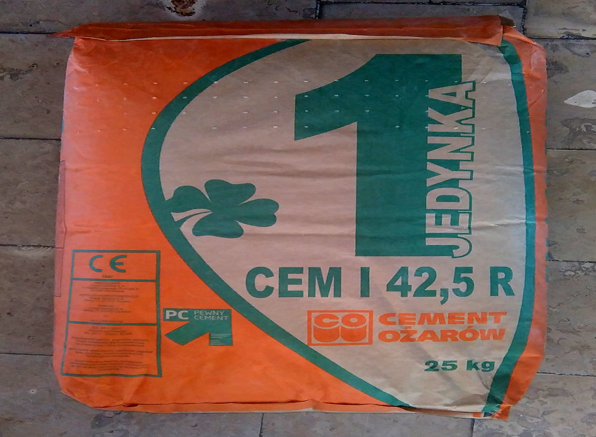

In [7]:
filepath = PATH / f'{PART}_images_v1' / data.iloc[1, 7]
raw_image = Image.open(filepath).convert("RGB")
print(filepath)
display(raw_image.resize((596, 437)))

In [8]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
caption = "serinus genus"

#### Load model and preprocessors

In [9]:
# model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "base", device=device, is_eval=True)
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "large", device=device, is_eval=True)

#### Preprocess image and text inputs

In [10]:
img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
txt = text_processors["eval"](caption)

NameError: name 'caption' is not defined

#### Compute image-text matching (ITM) score

In [12]:
itm_output = model({"image": img, "text_input": txt}, match_head="itm")
itm_scores = torch.nn.functional.softmax(itm_output, dim=1)
print(f'The image and text are matched with a probability of {itm_scores[:, 1].item():.3%}')

The image and text are matched with a probability of 1.034%


In [13]:
itc_score = model({"image": img, "text_input": txt}, match_head='itc')
print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)

The image feature and text feature has a cosine similarity of 0.1957


## Untrained BLIP for VWSD

#### TRAIN-VAL-TEST SPLIT

In [11]:
if PART == 'train':
    test_idx = pd.read_csv(PATH / f"split_test.txt", sep='\t', header=None).T.values[0]
    test_idx = test_idx[:100]
    df = data.loc[test_idx, :]
elif PART == 'test2':
    df = data.copy()
df

,word,context,image0,image1,image2,image3,image4,image5,image6,image7,image8,image9,image_gold
0,leucaena,leucaena genus,image.105.jpg,001546.jpg,000655.JPG,image.9520.jpg,image.15549.jpg,001206.JPG,001826.jpg,001597.jpg,002301.jpg,image.8849.jpg,image.105.jpg
1,mahonia,mahonia genus,001044.jpg,001674.jpg,000646.jpg,image.2680.jpg,001342.JPG,image.3494.jpg,000029.jpg,001720.jpg,image.120.jpg,image.2497.jpg,image.120.jpg
2,breakdown,breakdown failure,002145.jpg,image.7224.jpg,image.12060.jpg,image.8257.jpg,image.8257.jpg,image.239.jpg,image.9725.jpg,001788.jpg,image.5989.jpg,000801.jpg,image.239.jpg
3,boletellus,boletellus genus,image.6731.jpg,image.147.jpg,image.13701.jpg,image.13466.jpg,image.324.jpg,image.5049.jpg,000335.jpg,001961.JPG,001925.jpg,image.782.jpg,image.324.jpg
4,capparis,capparis genus,001593.jpg,001443.jpg,002213.jpg,image.359.jpg,image.6337.jpg,image.3602.jpg,000987.jpg,002117.JPG,image.5076.jpg,image.8718.jpg,image.359.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,aspergillus,aspergillus genus,image.593.jpg,000035.jpg,000389.jpg,image.5521.jpg,image.160.jpg,image.6272.jpg,image.8447.jpg,image.2497.jpg,image.10614.jpg,000567.jpg,image.10614.jpg
1555,mantophasmatodea,mantophasmatodea order,image.8286.jpg,image.5999.jpg,image.10599.jpg,image.3533.jpg,image.3355.jpg,002026.JPG,000778.jpg,001957.jpg,image.3467.jpg,002302.jpg,image.3355.jpg
1556,make,make persuade,image.10066.jpg,image.14200.jpg,image.8813.jpg,image.8879.jpg,002255.jpg,image.9126.jpg,image.14336.jpg,image.10167.jpg,001344.jpg,image.12437.jpg,image.9126.jpg
1557,lookout,lookout watcher,001229.jpg,001006.jpg,image.180.jpg,000790.jpg,001658.jpg,000994.jpg,001692.jpg,image.4060.jpg,000224.jpg,image.8805.jpg,image.4060.jpg


#### Attempt 1. ITM (Whole context vs. image)

In [13]:
USE_CACHING = True

img_cols = [f'image{i}' for i in range(10)]
res = []
if USE_CACHING:
    all_images = np.unique(df[img_cols].values.flatten())
    images = {k: Image.open(PATH / f'{PART}_images_v1' / k).convert("RGB").resize([224, 224]) for k in tqdm(all_images)} 


c:\Users\denis\miniconda3\lib\site-packages\PIL\JpegImagePlugin.py:812: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
c:\Users\denis\miniconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (110102544 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\denis\miniconda3\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
c:\Users\denis\miniconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (178315136 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 86%|████████▌ | 1344/1559 [11:31<01:50,  1.94it/s]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():

    for i, (_,row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
        caption = row['context']
        txt = text_processors["eval"](caption)
        ans = {}
        for j, img_path in enumerate(row.loc[img_cols]):
            if USE_CACHING:
                raw_image = images[img_path]
            else:
                raw_image = Image.open(PATH / f'{PART}_images_v1' / img_path).convert("RGB")

            img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

            itm_output = model({"image": img, "text_input": txt}, match_head="itm")
            itm_scores = torch.nn.functional.softmax(itm_output, dim=1)
            proba = itm_scores[:, 1].item()

            ans[img_path] = proba
        res.append(ans)

In [ ]:

evaluate(df.iloc[:, 2:-1].values, df.iloc[:, -1:].values, res)

In [ ]:

with torch.no_grad():

    for i, (_,row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
        caption = row['context']
        txt = text_processors["eval"](caption)
        ans = {}
        for j, img_path in enumerate(row.loc[img_cols]):
            if USE_CACHING:
                raw_image = images[img_path]
            else:
                raw_image = Image.open(PATH / f'{PART}_images_v1' / img_path).convert("RGB")

            img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

            itm_output = model({"image": img, "text_input": txt}, match_head="itm")
            itm_scores = torch.nn.functional.softmax(itm_output, dim=1)
            proba = itm_scores[:, 1].item()

            ans[img_path] = proba
        res.append(ans)
evaluate(df.iloc[:, 2:-1].values, df.iloc[:, -1:].values, res)

In [ ]:

with torch.no_grad():

    for i, (_,row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
        caption = row['context']
        txt = text_processors["eval"](caption)
        ans = {}
        for j, img_path in enumerate(row.loc[img_cols]):
            if USE_CACHING:
                raw_image = images[img_path]
            else:
                raw_image = Image.open(PATH / f'{PART}_images_v1' / img_path).convert("RGB")

            img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

            itm_output = model({"image": img, "text_input": txt}, match_head="itm")
            itm_scores = torch.nn.functional.softmax(itm_output, dim=1)
            proba = itm_scores[:, 1].item()

            ans[img_path] = proba
        res.append(ans)
evaluate(df.iloc[:, 2:-1].values, df.iloc[:, -1:].values, res)

In [ ]:

with torch.no_grad():

    for i, (_,row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
        caption = row['context']
        txt = text_processors["eval"](caption)
        ans = {}
        for j, img_path in enumerate(row.loc[img_cols]):
            if USE_CACHING:
                raw_image = images[img_path]
            else:
                raw_image = Image.open(PATH / f'{PART}_images_v1' / img_path).convert("RGB")

            img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

            itm_output = model({"image": img, "text_input": txt}, match_head="itm")
            itm_scores = torch.nn.functional.softmax(itm_output, dim=1)
            proba = itm_scores[:, 1].item()

            ans[img_path] = proba
        res.append(ans)
evaluate(df.iloc[:, 2:-1].values, df.iloc[:, -1:].values, res)

In [ ]:

with torch.no_grad():

    for i, (_,row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
        caption = row['context']
        txt = text_processors["eval"](caption)
        ans = {}
        for j, img_path in enumerate(row.loc[img_cols]):
            if USE_CACHING:
                raw_image = images[img_path]
            else:
                raw_image = Image.open(PATH / f'{PART}_images_v1' / img_path).convert("RGB")

            img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

            itm_output = model({"image": img, "text_input": txt}, match_head="itm")
            itm_scores = torch.nn.functional.softmax(itm_output, dim=1)
            proba = itm_scores[:, 1].item()

            ans[img_path] = proba
        res.append(ans)
evaluate(df.iloc[:, 2:-1].values, df.iloc[:, -1:].values, res)

#### Attempt 2. Cosine distance (Whole context vs. image)

In [19]:
USE_CACHING = True

img_cols = [f'image{i}' for i in range(10)]
res = []
if USE_CACHING:
    all_images = np.unique(df[img_cols].values.flatten())
    images = {k: Image.open(PATH / 'train_images_v1' / k).convert("RGB") for k in tqdm(all_images)} 

with torch.no_grad():
    for i, (_,row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
        caption = row['context']
        txt = text_processors["eval"](caption)
        ans = {}
        for j, img_path in enumerate(row.loc[img_cols]):
            if USE_CACHING:
                raw_image = images[img_path]
            else:
                raw_image = Image.open(PATH / 'train_images_v1' / img_path).convert("RGB")

            img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

            proba = model({"image": img, "text_input": txt}, match_head='itc')

            ans[img_path] = proba.item()

        res.append(ans)
evaluate(df.iloc[:, 2:-1].values, df.iloc[:, -1:].values, res)

 88%|████████▊ | 557/630 [00:18<00:01, 38.84it/s]c:\Users\denis\miniconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (89550550 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


{'acc1': 0.66, 'acc3': 0.85, 'mrr': 0.7678174603174603}

In [26]:
from lavis.models.blip_models.blip_image_text_matching import BlipITM
import torch
import torch.nn.functional as F
from lavis.common.registry import registry
from lavis.models.blip_models.blip import BlipBase
from torch import nn
from lavis.models.med import XBertEncoder

from lavis.models.vit import VisionTransformerEncoder

class BlipIWCM(BlipITM):
    def forward(self, samples, match_head="itm"):
        image = samples["image"]
        caption = samples["text_input"]

        image_embeds = self.visual_encoder.forward_features(image)
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(
            image.device
        )

        text = self.tokenizer(
            caption,
            padding="longest",
            truncation=True,
            max_length=self.max_txt_len,
            return_tensors="pt",
        ).to(image.device)
        if match_head == "itm":
            encoder_input_ids = text.input_ids.clone()
            encoder_input_ids[:, 0] = self.tokenizer.enc_token_id  # extra code
            output = self.text_encoder(
                encoder_input_ids,
                attention_mask=text.attention_mask,
                encoder_hidden_states=image_embeds,
                encoder_attention_mask=image_atts,
                return_dict=True,
            )
            itm_output = self.itm_head(output.last_hidden_state[:, 0, :])
            return itm_output

        elif match_head == "itc":
            text_output = self.text_encoder(
                text.input_ids,
                attention_mask=text.attention_mask,
                return_dict=True,
                mode="text",
            )
            image_feat = F.normalize(self.vision_proj(image_embeds[:, 0, :]), dim=-1)
            text_feat = F.normalize(
                self.text_proj(text_output.last_hidden_state[:, 0, :]), dim=-1
            )

            sim = image_feat @ text_feat.t()
            return sim



In [27]:
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "large", device=device, is_eval=True)
model.__class__ = BlipIWCM

In [28]:
USE_CACHING = True

img_cols = [f'image{i}' for i in range(10)]
res = []
if USE_CACHING and not images:
    all_images = np.unique(df[img_cols].values.flatten())
    images = {k: Image.open(PATH / 'train_images_v1' / k).convert("RGB").resize([224, 224]) for k in tqdm(all_images)} 

with torch.no_grad():

    for i, (_,row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
        caption = row['context']
        txt = text_processors["eval"](caption)
        ans = {}
        for j, img_path in enumerate(row.loc[img_cols]):
            if USE_CACHING:
                raw_image = images[img_path]
            else:
                raw_image = Image.open(PATH / 'train_images_v1' / img_path).convert("RGB")

            img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

            itm_output = model({"image": img, "text_input": txt}, match_head="itm")
            itm_scores = torch.nn.functional.softmax(itm_output, dim=1)
            proba = itm_scores[:, 1].item()

            ans[img_path] = proba
        res.append(ans)
evaluate(df.iloc[:, 2:-1].values, df.iloc[:, -1:].values, res)

  0%|          | 0/100 [00:00<?, ?it/s]Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
Using eos_token, but it is not set yet.
